In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.metrics import roc_curve, auc
from sklearn.svm import LinearSVC
from sklearn.svm import SVC
from textblob import TextBlob

In [21]:
data = pd.read_csv('f_clean.csv')

In [22]:
data.loc[data['score'] < 3, 'score'] = -1
data.loc[data['score'] == 3, 'score'] = 0
data.loc[data['score'] > 3, 'score'] = 1

In [24]:
# print(data.columns)
# data.drop(columns=['Unnamed: 0','Unnamed: 0.1'],inplace=True)
testset = data[:1000000]
testset.reset_index(drop=True)
trainset = data[1000000:]
trainset.reset_index(drop=True)


,Unnamed: 0,Unnamed: 0.1,text,score
0,1000008,1000008,loved ergo proxy ever since came back art extr...,1.0
1,1000009,1000009,one favorite series fans bladerunner ghost she...,1.0
2,1000010,1000010,absolutely love series watched ever since came...,1.0
3,1000011,1000011,spoiler free short review ergo proxy brilliant...,1.0
4,1000012,1000012,kick review like say really much enjoyment wat...,1.0
...,...,...,...,...
499091,1499102,1499102,fan alex loughlin since cbs drama moonlight qu...,1.0
499092,1499103,1499103,movie reminded classic well written psychologi...,1.0
499093,1499104,1499104,truly obese women men feed thing deliberately ...,-1.0
499094,1499105,1499105,really star star originality tried stick one h...,-1.0


In [25]:
x_train, x_validation, y_train, y_validation = train_test_split(trainset.text, trainset.score, test_size=0.2, random_state=1234)
print("trainset size: {}, {} positive, {} negtive, {} neural.".format(len(y_train),len(y_train[y_train>3]),len(y_train[y_train < 3]),len(y_train[y_train == 3])))
print("validationset size: {}, {}positive, {} negtive, {} neural.".format(len(y_validation),len(y_validation[y_validation>3]),len(y_validation[y_validation < 3]),len(y_validation[y_validation == 3])))

trainset size: 399276, 0 positive, 399276 negtive, 0 neural.
validationset size: 99820, 0positive, 99820 negtive, 0 neural.


In [26]:
tb_sent = [TextBlob(i).sentiment.polarity for i in x_validation]
for idx,x in enumerate(tb_sent):
    if x < 0:
        tb_sent[idx] = -1
    elif x > 0:
        tb_sent[idx] = 1

In [13]:
y_validation

1451935   -1.0
1393170   -1.0
1395961   -1.0
1362930   -1.0
1446181    0.0
          ... 
1092921    0.0
1080601    0.0
1165262   -1.0
1053363   -1.0
1212075   -1.0
Name: score, Length: 99820, dtype: float64

In [27]:
cm = confusion_matrix(y_validation, tb_sent)
cm

array([[ 5586,   292,  7985],
       [ 1371,    83,  8585],
       [ 4185,   865, 70868]], dtype=int64)

<AxesSubplot:>

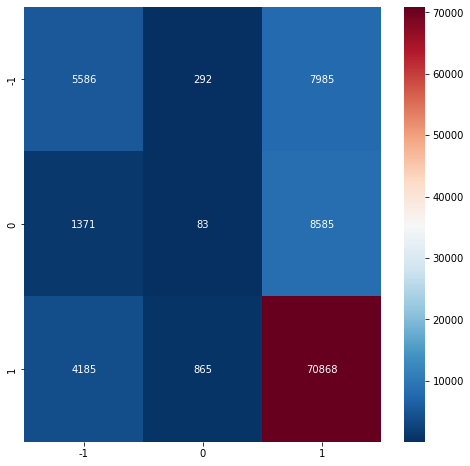

In [38]:
import seaborn as sns
sns.set_context({'figure.figsize':(8,8)})
ax = ['-1','0','1']
sns.heatmap(cm,annot=True,fmt='d',cmap='RdBu_r',xticklabels=ax, yticklabels=ax)



In [28]:
print('accuracy = {}'.format(accuracy_score(y_validation, tb_sent)))
print(classification_report(y_validation, tb_sent))

accuracy = 0.7667501502704869
              precision    recall  f1-score   support

        -1.0       0.50      0.40      0.45     13863
         0.0       0.07      0.01      0.01     10039
         1.0       0.81      0.93      0.87     75918

    accuracy                           0.77     99820
   macro avg       0.46      0.45      0.44     99820
weighted avg       0.69      0.77      0.72     99820



In [39]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression


In [41]:
vec = CountVectorizer()
clf = MultinomialNB()


In [44]:
def word_freq(data, max_features):
    count_vec = CountVectorizer(stop_words = 'english', max_feature = max_features)
    count_vec.fit(data.text)
    print('number of unique words:'+ str(len(count_vec.get_feature_names())))

    neg_mat = count_vec.transform(data[data.score < 3].text)
    pos_mat = count_vec.transform(data[data.score > 3].text)
    neu_mat = count_vec.transform(data[data.score == 3].text)
    neg_freq = np.squeeze(np.asarray(np.sum(neg_mat, axis=0)))
    pos_freq = np.squeeze(np.asarray(np.sum(pos_mat, axis=0)))
    neu_freq = np.squeeze(np.asarray(np.sum(neu_mat, axis=0)))

    df_freq = pd.DataFrame([neg_freq, neu_freq, pos_freq], columns=count_vec.get_feature_names()).transpose()
    df_freq.columns = ['neg','neu','pos']
    df_freq['total'] = df_freq['neg'] + df_freq['neu'] + df_freq['pos']
    df_freq = df_freq.sort_values('total', ascending=False)

    return df_freq

In [52]:
df_freq = pd.read_csv('df_freq.csv')
# df_freq.drop(columns=['Unnamed: 0'], inplace=True)
df_freq.rename(columns={'Unnamed: 0':'words'},inplace=True)

In [55]:
# custom_stopwords = list(df_freq.head(25).words)
from time import time
def calc_accuracy(pipeline, X_train, X_test, y_train, y_test):
    t0 = time()
    sentiment_clf = pipeline.fit(X_train, y_train)
    y_pred = sentiment_clf.predict(X_test)
    train_test_time = time() - t0
    accuracy = accuracy_score(y_test, y_pred)
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    fpr, tpr, _ = roc_curve(y_test, y_pred, pos_label=1)
    roc_auc = auc(fpr, tpr)
    
    print("model accuracy : {0:.2f}".format(accuracy))
    print("model auc : {0:.2f}".format(roc_auc))
    print("train validation time : {0:.2f}s".format(train_test_time))
    print("=========================================================")
    
    return accuracy, roc_auc, train_test_time

In [58]:
from sklearn.pipeline import Pipeline
n_features = np.arange(10000, 100001,10000)
def compare_clf_nfeature(X_train, X_test, y_train, y_test, vectorizer=vec, clf=clf, n_features=n_features, stop_words=None, ngram_range = (1,1)):
    res = []
    print(clf)
    for feature in n_features:
        vectorizer.set_params(stop_words=stop_words, ngram_range=ngram_range, max_features=feature)
        acc_pipeline = Pipeline([('vectorizer', vectorizer), ('classifier', clf)])
        print("result on model with {} features".format(feature))
        accuracy, auc, time = calc_accuracy(acc_pipeline, X_train, X_test, y_train, y_test)
        res.append((feature, accuracy, auc, time))
        
    return res

In [59]:
results = compare_clf_nfeature(x_train, x_validation, y_train, y_validation)

MultinomialNB()
result on model with 10000 features
model accuracy : 0.78
model auc : 0.80
train validation time : 32.62s
result on model with 20000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 31.67s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 31.71s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 31.87s
result on model with 50000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 31.91s
result on model with 60000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 31.97s
result on model with 70000 features
model accuracy : 0.79
model auc : 0.81
train validation time : 31.96s
result on model with 80000 features
model accuracy : 0.79
model auc : 0.81
train validation time : 32.05s
result on model with 90000 features
model accuracy : 0.79
model auc : 0.81
train validation time : 32.05s
result on model with 100000 fe

In [60]:
results_stop_eng = compare_clf_nfeature(x_train, x_validation, y_train, y_validation, stop_words='english')

MultinomialNB()
result on model with 10000 features
model accuracy : 0.78
model auc : 0.80
train validation time : 32.07s
result on model with 20000 features
model accuracy : 0.78
model auc : 0.80
train validation time : 32.28s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.80
train validation time : 32.30s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 32.33s
result on model with 50000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 32.33s
result on model with 60000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 32.48s
result on model with 70000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 32.55s
result on model with 80000 features
model accuracy : 0.79
model auc : 0.81
train validation time : 32.43s
result on model with 90000 features
model accuracy : 0.79
model auc : 0.81
train validation time : 32.49s
result on model with 100000 fe

In [61]:
cols = ['n_features', 'val_acc', 'val_auc','time']
results = pd.DataFrame(results,columns=cols)
results_stop_eng = pd.DataFrame(results_stop_eng, columns=cols)


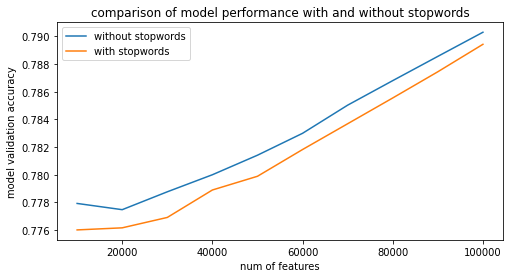

In [62]:
plt.figure(figsize=(8,4))
plt.plot(results.n_features, results.val_acc, label='without stopwords')
plt.plot(results_stop_eng.n_features, results_stop_eng.val_acc, label='with stopwords')
plt.title('comparison of model performance with and without stopwords')
plt.xlabel('num of features')
plt.ylabel('model validation accuracy')
plt.legend()

In [63]:
res_bigram = compare_clf_nfeature(x_train, x_validation, y_train, y_validation, ngram_range=(1,2))

MultinomialNB()
result on model with 10000 features
model accuracy : 0.78
model auc : 0.81
train validation time : 128.95s
result on model with 20000 features
model accuracy : 0.78
model auc : 0.82
train validation time : 137.52s
result on model with 30000 features
model accuracy : 0.78
model auc : 0.83
train validation time : 132.56s
result on model with 40000 features
model accuracy : 0.78
model auc : 0.83
train validation time : 130.51s
result on model with 50000 features
model accuracy : 0.78
model auc : 0.83
train validation time : 130.41s
result on model with 60000 features
model accuracy : 0.79
model auc : 0.83
train validation time : 130.11s
result on model with 70000 features
model accuracy : 0.79
model auc : 0.84
train validation time : 130.66s
result on model with 80000 features
model accuracy : 0.79
model auc : 0.84
train validation time : 129.97s
result on model with 90000 features
model accuracy : 0.79
model auc : 0.84
train validation time : 130.17s
result on model with 